In [1]:
import pandas as pd

In [2]:
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_cats.txt

--2021-12-28 08:54:48--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228391 (223K) [text/plain]
Saving to: ‘train_aspects.txt.1’

train_aspects.txt.1 100%[===================>] 223.04K  --.-KB/s    in 0.03s   

2021-12-28 08:54:48 (8.14 MB/s) - ‘train_aspects.txt.1’ saved [228391/228391]

--2021-12-28 08:54:48--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

In [3]:
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_aspects.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_reviews.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_cats.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_pred_aspects.txt

--2021-12-28 08:54:49--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_aspects.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57508 (56K) [text/plain]
Saving to: ‘dev_aspects.txt.1’

dev_aspects.txt.1   100%[===================>]  56.16K  --.-KB/s    in 0.01s   

2021-12-28 08:54:49 (5.43 MB/s) - ‘dev_aspects.txt.1’ saved [57508/57508]

--2021-12-28 08:54:49--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 20

In [4]:
! pip install pymorphy2

In [5]:
import pandas as pd
import numpy as np

from collections import Counter
import re

import pymorphy2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import statistics
import seaborn as sn
import matplotlib.pyplot  as plt
from sklearn.metrics import classification_report, confusion_matrix

from time import time


import joblib
import json
import warnings
warnings.filterwarnings('ignore')


In [6]:
! pip install stanza

In [7]:
! wget https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/kartaslovsent/kartaslovsent.csv

--2021-12-28 08:55:01--  https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/kartaslovsent/kartaslovsent.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2655438 (2.5M) [text/plain]
Saving to: ‘kartaslovsent.csv.1’

kartaslovsent.csv.1 100%[===================>]   2.53M  --.-KB/s    in 0.07s   

2021-12-28 08:55:01 (36.2 MB/s) - ‘kartaslovsent.csv.1’ saved [2655438/2655438]



In [8]:
! wget http://www.labinform.ru/pub/rusentilex/rusentilex_2017.txt

--2021-12-28 08:55:01--  http://www.labinform.ru/pub/rusentilex/rusentilex_2017.txt
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1329241 (1.3M) [text/plain]
Saving to: ‘rusentilex_2017.txt.1’

rusentilex_2017.txt 100%[===================>]   1.27M  1.55MB/s    in 0.8s    

2021-12-28 08:55:03 (1.55 MB/s) - ‘rusentilex_2017.txt.1’ saved [1329241/1329241]



In [9]:
from nltk.corpus import stopwords
from string import punctuation
import string
import csv
import stanza
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
words_sentilex = {}
with open('rusentilex_2017.txt','r') as f:
  file = csv.reader(f,delimiter = '\n')
  for k in file:
    try:
      k = k[0]
      if k.startswith('!'):
        pass
      else:
        k = k.split(',')
        words_sentilex[k[0]] = k[3]
    except:
      pass

In [11]:
words_kartaslov = {}
with open('kartaslovsent.csv','r') as f:
  file = csv.reader(f,delimiter = '\n')
  for k in file:
    try:
      k = k[0]
      k = k.split(';')
      if k[1] == 'PSTV':
        words_kartaslov[k[0]] = 'positive'
      elif k[1] == 'NGTV':
        words_kartaslov[k[0]] = 'negative'
      elif k[1] == 'NEUT':
        words_kartaslov[k[0]] = 'neutral'
    except:
      pass

In [12]:
train_asp = pd.read_csv(
    'train_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_reviews.txt', delimiter='\t', names=['text_id','text'])


test_asp = pd.read_csv(
    'dev_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
test_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id','text'])

In [13]:
def punct(text):
  for k in string.punctuation:
    text = text.replace(k, ' ')
  text = text.split()
  for i in stopwords:
    for el in text:
      if i == el:
        text.remove(i)
  return ' '.join(text)

In [14]:
train_texts['clean_text'] = train_texts['text'].apply(lambda x: punct(x))

In [15]:
test_texts['clean_text'] = test_texts['text'].apply(lambda x: punct(x))

In [16]:
test_texts

,text_id,text,clean_text
0,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...",Зашли аппетит случайно Не смотря будний день в...
1,1427,Здравствуйте!Посетили ваше заведение вчера пер...,Здравствуйте Посетили ваше заведение вчера пер...
2,16714,"Были в пятницу (19.03.10), заказывали столик д...",Были пятницу 19 03 10 заказывали столик родите...
3,797,"Были в ресторане 2 раза. Один раз днем, все по...",Были ресторане 2 раза Один днем понравилось вт...
4,34710,Удивляюсь отзывам про хорошее обслуживание. Бы...,Удивляюсь отзывам хорошее обслуживание Были 4 ...
...,...,...,...
66,9216,Вы брали этот ресторан так как он близко от до...,Вы брали ресторан близко дома подходит свадебн...
67,8996,"Были с друзьями в пабе Метрополь, всё очень по...",Были друзьями пабе Метрополь всё очень понрави...
68,38299,"Случайно увидели акцию на сайте купонов, решил...",Случайно увидели акцию сайте купонов решили пр...
69,37819,Очень долго выбирали ресторан на Новогодний ка...,Очень долго выбирали ресторан Новогодний карпо...


In [17]:
import stanza

In [18]:
stanza.download('ru')

2021-12-28 08:55:05 INFO: Downloading default packages for language: ru (Russian)...
2021-12-28 08:55:07 INFO: File exists: /root/stanza_resources/ru/default.zip.
2021-12-28 08:55:19 INFO: Finished downloading models and saved to /root/stanza_resources.


In [19]:
nlp = stanza.Pipeline('ru', processors='tokenize,pos,lemma')

2021-12-28 08:55:19 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |

2021-12-28 08:55:19 INFO: Use device: cpu
2021-12-28 08:55:19 INFO: Loading: tokenize
2021-12-28 08:55:19 INFO: Loading: pos
2021-12-28 08:55:19 INFO: Loading: lemma
2021-12-28 08:55:20 INFO: Done loading processors!


In [20]:
# reviews_train = pd.DataFrame({'Text_id': reviews.keys(), 'Text': reviews.values()})

In [21]:
# reviews_train

In [22]:
train_reviews = []
for el in range(len(train_texts.clean_text)):
  train_reviews.append((train_texts.text_id[el],train_texts.clean_text[el]))

In [23]:
test_reviews = []
for el in range(len(test_texts.clean_text)):
  test_reviews.append((test_texts.text_id[el],test_texts.clean_text[el]))

In [24]:
test_texts

,text_id,text,clean_text
0,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...",Зашли аппетит случайно Не смотря будний день в...
1,1427,Здравствуйте!Посетили ваше заведение вчера пер...,Здравствуйте Посетили ваше заведение вчера пер...
2,16714,"Были в пятницу (19.03.10), заказывали столик д...",Были пятницу 19 03 10 заказывали столик родите...
3,797,"Были в ресторане 2 раза. Один раз днем, все по...",Были ресторане 2 раза Один днем понравилось вт...
4,34710,Удивляюсь отзывам про хорошее обслуживание. Бы...,Удивляюсь отзывам хорошее обслуживание Были 4 ...
...,...,...,...
66,9216,Вы брали этот ресторан так как он близко от до...,Вы брали ресторан близко дома подходит свадебн...
67,8996,"Были с друзьями в пабе Метрополь, всё очень по...",Были друзьями пабе Метрополь всё очень понрави...
68,38299,"Случайно увидели акцию на сайте купонов, решил...",Случайно увидели акцию сайте купонов решили пр...
69,37819,Очень долго выбирали ресторан на Новогодний ка...,Очень долго выбирали ресторан Новогодний карпо...


In [25]:
# здесь код для упоминаний из 1 токена
# ВАЖНО: для более длинных упоминаний нужно доделать ещё немного
all_data_train = []
for text_id, text in train_reviews:
  processed = nlp(text)
  for token in processed.iter_tokens():
    all_data_train.append([text_id, token.text, token.words[0].pos, token.words[0].lemma])

In [26]:
all_data_test = []
for text_id, text in test_reviews:
  processed = nlp(text)
  for token in processed.iter_tokens():
    all_data_test.append([text_id, token.text, token.words[0].pos, token.words[0].lemma])

In [27]:
train_data = pd.DataFrame(all_data_train, columns=['Text_id', 'Token', 'POS-tag', 'Lemma'])

In [28]:
train_data.head()

,Text_id,Token,POS-tag,Lemma
0,3976,День,NOUN,день
1,3976,8,NUM,8
2,3976,го,NOUN,го
3,3976,марта,NOUN,март
4,3976,прошёл,VERB,пройти


In [29]:
test_data = pd.DataFrame(all_data_test, columns=['Text_id', 'Token', 'POS-tag', 'Lemma'])

In [30]:
test_data.head()

,Text_id,Token,POS-tag,Lemma
0,13823,Зашли,VERB,зайти
1,13823,аппетит,NOUN,аппетит
2,13823,случайно,ADV,случайно
3,13823,Не,PART,не
4,13823,смотря,VERB,смотреть


In [31]:
train_asp.head()

,text_id,category,mention,start,end,sentiment
0,3976,Whole,ресторане,71,80,neutral
1,3976,Whole,ресторанах,198,208,neutral
2,3976,Whole,ресторане,256,265,neutral
3,3976,Service,Столик бронировали,267,285,neutral
4,3976,Service,администратор,322,335,positive


In [32]:
del train_asp['start']
del train_asp['end']
del test_asp['start']
del test_asp['end']

In [33]:
splitted_train = []
for i in range(len(train_asp.text_id)):
  for l in train_asp.mention[i].split():
    splitted_train.append([train_asp.text_id[i], train_asp.category[i], l, train_asp.sentiment[i]])

In [34]:
splitted_test = []
for i in range(len(test_asp.text_id)):
  for l in test_asp.mention[i].split():
    splitted_test.append([test_asp.text_id[i], test_asp.category[i], l, test_asp.sentiment[i]])

In [35]:
text_id_split = []
category_split = []
tokens = []
lemmas = []
sentiments = []
for k in splitted_train:
  text_id_split.append(k[0])
  category_split.append(k[1])
  tokens.append(k[2])
  sentiments.append(k[3])

In [36]:
text_id_split_test = []
category_split_test = []
tokens_test = []
lemmas_test = []
sentiments_test = []
for k in splitted_test:
  text_id_split_test.append(k[0])
  category_split_test.append(k[1])
  tokens_test.append(k[2])
  sentiments_test.append(k[3])

In [37]:
nlp = stanza.Pipeline('ru', processors='tokenize,pos,lemma')

2021-12-28 08:57:10 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |

2021-12-28 08:57:10 INFO: Use device: cpu
2021-12-28 08:57:10 INFO: Loading: tokenize
2021-12-28 08:57:10 INFO: Loading: pos
2021-12-28 08:57:10 INFO: Loading: lemma
2021-12-28 08:57:11 INFO: Done loading processors!


In [38]:
splitted_train_df = pd.DataFrame({'Text_id': text_id_split, 'Category':category_split, 'Mention':tokens , 'Sentiment':sentiments})

In [39]:
splitted_test_df = pd.DataFrame({'Text_id': text_id_split_test, 'Category':category_split_test, 'Mention':tokens_test , 'Sentiment':sentiments_test})

In [40]:
tokens2 = []
for k in range(len(splitted_train_df.Mention)):
  processed = nlp(splitted_train_df.Mention[k])
  for token in processed.iter_tokens():
    tokens2.append([splitted_train_df.Mention[k], token.words[0].lemma, splitted_train_df.Sentiment[k]])


In [41]:
tokens2test = []
for k in range(len(splitted_test_df.Mention)):
  processed = nlp(splitted_test_df.Mention[k])
  for token in processed.iter_tokens():
    tokens2test.append([splitted_test_df.Mention[k], token.words[0].lemma, splitted_test_df.Sentiment[k]])

In [42]:
train_dict = {}
for el in tokens2:
  train_dict[el[1]] = el[2]

In [43]:
test_dict = {}
for el in tokens2test:
  test_dict[el[1]] = el[2]

In [44]:
all_sentiments = []
for k in train_data.Lemma:
  try:
    all_sentiments.append(train_dict[k])
  except:
    try:
      all_sentiments.append(words_kartaslov[k])
    except:
      try:
        all_sentiments.append(words_sentilex[k])
      except:
        all_sentiments.append(None)

In [45]:
all_sentiments_test = []
for k in test_data.Lemma:
  try:
    all_sentiments_test.append(test_dict[k])
  except:
    try:
      all_sentiments_test.append(words_kartaslov[k])
    except:
      try:
        all_sentiments_test.append(words_sentilex[k])
      except:
        all_sentiments_test.append(None)

In [46]:
train_data['sentiment'] = all_sentiments

In [47]:
test_data['sentiment'] = all_sentiments_test

In [48]:
train_data = train_data.dropna()

In [49]:
test_data = test_data.dropna()

In [50]:
sentiment_train_right = []
for el in train_data.sentiment:
  if el == 'neutral':
    sentiment_train_right.append('neutral')
  elif el == 'positive':
    sentiment_train_right.append('positive')
  elif el == 'negative':
    sentiment_train_right.append('negative')
  elif el == 'both':
    sentiment_train_right.append('both')
  elif el == ' positive':
    sentiment_train_right.append('positive')
  elif el ==' negative':
    sentiment_train_right.append('negative')
  elif el == ' neutral':
    sentiment_train_right.append('neutral')
  elif el == ' positive/negative':
    sentiment_train_right.append('both')

In [51]:
sentiment_test_right = []
for el in test_data.sentiment:
  if el == 'neutral':
    sentiment_test_right.append('neutral')
  elif el == 'positive':
    sentiment_test_right.append('positive')
  elif el == 'negative':
    sentiment_test_right.append('negative')
  elif el == 'both':
    sentiment_test_right.append('both')
  elif el == ' positive':
    sentiment_test_right.append('positive')
  elif el ==' negative':
    sentiment_test_right.append('negative')
  elif el == ' neutral':
    sentiment_test_right.append('neutral')
  elif el == ' positive/negative':
    sentiment_test_right.append('both')

In [52]:
train_data['sentiment_right'] = sentiment_train_right

In [53]:
test_data['sentiment_right'] = sentiment_test_right

In [54]:
train_data.head()

,Text_id,Token,POS-tag,Lemma,sentiment,sentiment_right
0,3976,День,NOUN,день,neutral,neutral
2,3976,го,NOUN,го,neutral,neutral
3,3976,марта,NOUN,март,neutral,neutral
4,3976,прошёл,VERB,пройти,positive,positive
5,3976,итоги,NOUN,итог,neutral,neutral


In [55]:
test_data.head()

,Text_id,Token,POS-tag,Lemma,sentiment,sentiment_right
0,13823,Зашли,VERB,зайти,positive,positive
1,13823,аппетит,NOUN,аппетит,neutral,neutral
4,13823,смотря,VERB,смотреть,neutral,neutral
5,13823,будний,ADJ,будний,neutral,neutral
6,13823,день,NOUN,день,neutral,neutral


In [56]:
def text_cls(CLS_ALGORITHM,X_train,  y_train, X_test, y_test, path_save):
    if CLS_ALGORITHM == 'LogisticRegression':
        nb =  Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', LogisticRegression())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
                         'clf__penalty': ( "l1", "l2"),
                         'clf__C': (1.5, 1, 0.5),
                         'clf__class_weight': ['balanced']}
 
    elif CLS_ALGORITHM == 'MultinomialNB':
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf',MultinomialNB())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
               'clf__alpha': ( 0.01, 0.001)}
    elif CLS_ALGORITHM == 'RandomForestClassifier':   
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', RandomForestClassifier())])
 
 
        parameters_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'clf__class_weight': ("balanced", "balances_subsample")}
    else:
      nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', PassiveAggressiveClassifier())])
      parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
               'clf__max_iter': ( 1000, 2000),
               'clf__C': (1.5, 1, 0.5),} 

    gs_clf_nb = GridSearchCV(nb, parameters_nb, n_jobs=-1, scoring = "f1_weighted")

    
    gs_clf_nb = gs_clf_nb.fit(X_train.to_list(), y_train.to_list())
    print(gs_clf_nb.best_score_)
    print(gs_clf_nb.best_params_)
    r = gs_clf_nb.best_estimator_
    predicted = r.predict(X_test.to_list())
    joblib.dump(r, f'{path_save}_{CLS_ALGORITHM}.pkl')
    return y_test, predicted

In [57]:
def visualize(y_true, y_pred, df, target_column, new_path):
    plt.figure(figsize=(7,5))
    array=confusion_matrix(y_true, y_pred)
    a = [sorted(df[target_column].unique())]
    df_cm = pd.DataFrame(array, index=a, columns=a)
    sn.set(font_scale=1.2)
    sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
    plt.xticks(rotation=60)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Реальный класс')
    plt.savefig(new_path + '_'+ 'image.png')
    plt.show()


0.6033956330680661
{'clf__alpha': 0.01, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

        both       1.00      0.32      0.48        19
    negative       0.79      0.56      0.65       160
     neutral       0.79      0.58      0.67       216
    positive       0.83      0.95      0.88       795

    accuracy                           0.82      1190
   macro avg       0.85      0.60      0.67      1190
weighted avg       0.82      0.82      0.81      1190



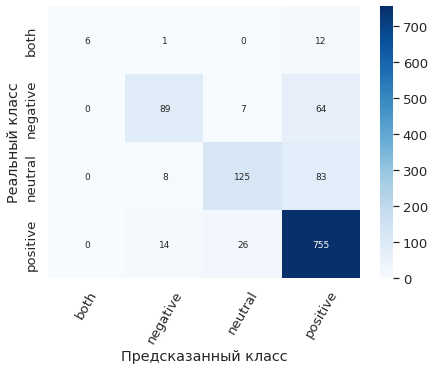

In [58]:
y_test, predicted = text_cls('MultinomialNB',train_asp['mention'],  train_asp['sentiment'], test_asp['mention'], test_asp['sentiment'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_asp, 'sentiment', './')



0.884896381745557
{'clf__alpha': 0.01, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

        both       0.14      0.77      0.24        13
    negative       0.66      0.79      0.72       378
     neutral       0.96      0.72      0.82      2107
    positive       0.80      0.93      0.86      2595

    accuracy                           0.83      5093
   macro avg       0.64      0.80      0.66      5093
weighted avg       0.85      0.83      0.83      5093



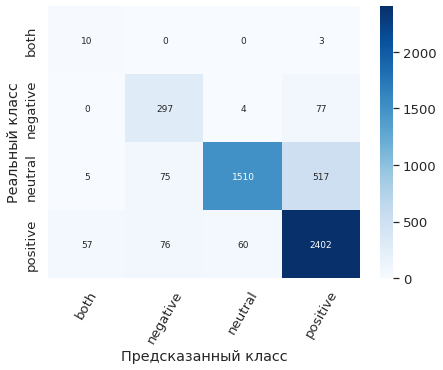

In [59]:
y_test, predicted = text_cls('MultinomialNB',train_data['Token'],  train_data['sentiment_right'], test_data['Token'], test_data['sentiment_right'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_data, 'sentiment_right', './')

In [60]:
for k in range(len(test_data['Token'].tolist())):
  if y_test.tolist()[k] !=  predicted[k]:
    print(test_data['Token'].tolist()[k])
    print('REAL:', y_test.tolist()[k])
    print('PREDICTED:', predicted[k])


аппетит
REAL: neutral
PREDICTED: negative
смотря
REAL: neutral
PREDICTED: positive
народа
REAL: neutral
PREDICTED: positive
остаться
REAL: neutral
PREDICTED: positive
менеджер
REAL: neutral
PREDICTED: positive
официантка
REAL: negative
PREDICTED: positive
Посмотрев
REAL: neutral
PREDICTED: positive
заведения
REAL: neutral
PREDICTED: negative
прошло
REAL: neutral
PREDICTED: positive
ланч
REAL: positive
PREDICTED: negative
очень
REAL: neutral
PREDICTED: positive
В
REAL: neutral
PREDICTED: positive
очень
REAL: neutral
PREDICTED: positive
очень
REAL: neutral
PREDICTED: positive
заведению
REAL: neutral
PREDICTED: negative
заведение
REAL: neutral
PREDICTED: negative
первый
REAL: positive
PREDICTED: neutral
ужинали
REAL: neutral
PREDICTED: positive
остались
REAL: neutral
PREDICTED: positive
очень
REAL: neutral
PREDICTED: positive
заведения
REAL: neutral
PREDICTED: negative
человек
REAL: positive
PREDICTED: negative
присесть
REAL: neutral
PREDICTED: positive
подала
REAL: negative
PREDICTED: po

0.884896381745557
{'clf__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 1)}
              precision    recall  f1-score   support

        both       0.14      0.77      0.24        13
    negative       0.66      0.79      0.72       378
     neutral       0.96      0.72      0.82      2107
    positive       0.80      0.93      0.86      2595

    accuracy                           0.83      5093
   macro avg       0.64      0.80      0.66      5093
weighted avg       0.85      0.83      0.83      5093



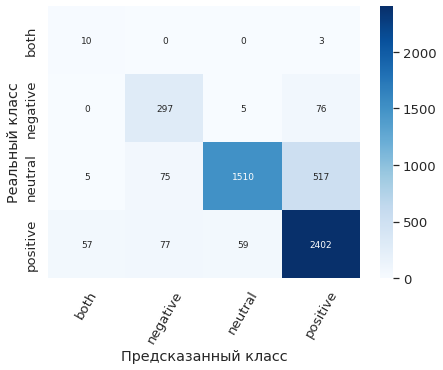

In [61]:
y_test, predicted = text_cls('RandomForestClassifier', train_data['Token'], train_data['sentiment_right'], test_data['Token'], test_data['sentiment_right'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_data, 'sentiment_right', './')

0.8848492206864021
{'clf__C': 1.5, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

        both       0.14      0.77      0.24        13
    negative       0.66      0.79      0.72       378
     neutral       0.96      0.72      0.82      2107
    positive       0.80      0.93      0.86      2595

    accuracy                           0.83      5093
   macro avg       0.64      0.80      0.66      5093
weighted avg       0.85      0.83      0.83      5093



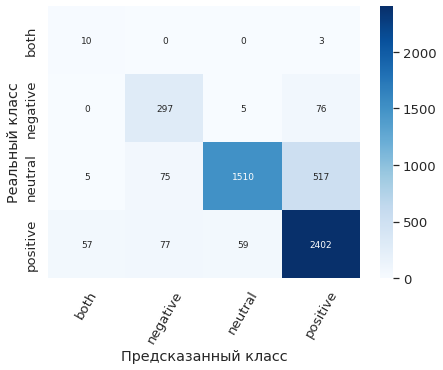

In [62]:
y_test, predicted = text_cls('LogisticRegression',train_data['Token'],  train_data['sentiment_right'], test_data['Token'], test_data['sentiment_right'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_data, 'sentiment_right', './')

0.8848997460220781
{'clf__C': 1, 'clf__max_iter': 2000, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

        both       0.14      0.77      0.24        13
    negative       0.66      0.79      0.72       378
     neutral       0.96      0.72      0.82      2107
    positive       0.80      0.93      0.86      2595

    accuracy                           0.83      5093
   macro avg       0.64      0.80      0.66      5093
weighted avg       0.85      0.83      0.83      5093



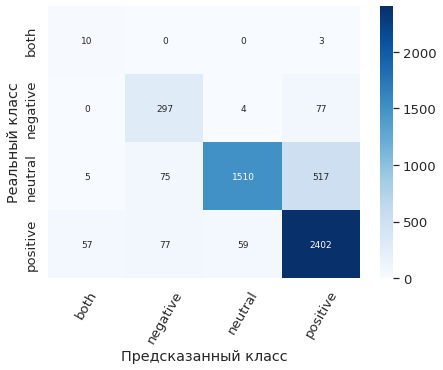

In [63]:
y_test, predicted = text_cls('PassiveAgressive',train_data['Token'],  train_data['sentiment_right'], test_data['Token'], test_data['sentiment_right'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_data, 'sentiment_right', './')

In [64]:
test_data

,Text_id,Token,POS-tag,Lemma,sentiment,sentiment_right
0,13823,Зашли,VERB,зайти,positive,positive
1,13823,аппетит,NOUN,аппетит,neutral,neutral
4,13823,смотря,VERB,смотреть,neutral,neutral
5,13823,будний,ADJ,будний,neutral,neutral
6,13823,день,NOUN,день,neutral,neutral
...,...,...,...,...,...,...
6442,11770,В,ADP,в,neutral,neutral
6443,11770,общем,ADJ,общий,positive,positive
6444,11770,ресторан,NOUN,ресторан,positive,positive
6445,11770,высокого,ADJ,высокий,neutral,neutral


0.603063014314227
{'clf__C': 0.5, 'clf__max_iter': 2000, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

        both       1.00      0.32      0.48        19
    negative       0.84      0.47      0.61       160
     neutral       0.74      0.63      0.68       216
    positive       0.83      0.95      0.88       795

    accuracy                           0.82      1190
   macro avg       0.85      0.59      0.66      1190
weighted avg       0.82      0.82      0.80      1190



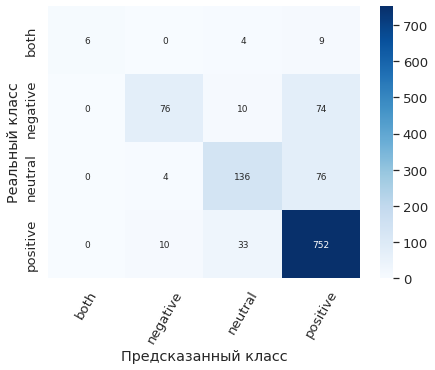

In [65]:
y_test, predicted = text_cls('PassiveAggressiveClassifier',train_asp['mention'],  train_asp['sentiment'], test_asp['mention'], test_asp['sentiment'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_asp, 'sentiment', './')


In [66]:
for k in range(len(test_asp['mention'].tolist())):
  if y_test.tolist()[k] !=  predicted[k]:
    print(test_asp['mention'].tolist()[k])
    print('REAL:', y_test.tolist()[k])
    print('PREDICTED:', predicted[k])

ресторанах
REAL: neutral
PREDICTED: negative
ресторан
REAL: neutral
PREDICTED: positive
Обслуживание
REAL: both
PREDICTED: positive
официанта
REAL: negative
PREDICTED: positive
блюдо
REAL: neutral
PREDICTED: positive
Порции
REAL: negative
PREDICTED: positive
кафе
REAL: positive
PREDICTED: neutral
кафе
REAL: positive
PREDICTED: neutral
котлетки
REAL: neutral
PREDICTED: positive
роллы
REAL: neutral
PREDICTED: positive
Ролл
REAL: positive
PREDICTED: neutral
блюда
REAL: negative
PREDICTED: positive
официанту
REAL: neutral
PREDICTED: positive
шеф-повар
REAL: neutral
PREDICTED: positive
меню
REAL: neutral
PREDICTED: positive
администраторы
REAL: neutral
PREDICTED: positive
меню
REAL: neutral
PREDICTED: positive
покушать
REAL: neutral
PREDICTED: positive
Ресторан
REAL: neutral
PREDICTED: positive
ценник
REAL: positive
PREDICTED: negative
пиво
REAL: neutral
PREDICTED: positive
встретил
REAL: neutral
PREDICTED: positive
менеджер
REAL: neutral
PREDICTED: negative
девушка
REAL: neutral
PREDICTED:

В текстовый документ выведем лучший классификатор:

0.884901823486208
{'clf__C': 1, 'clf__max_iter': 2000, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

        both       0.14      0.77      0.24        13
    negative       0.66      0.79      0.72       378
     neutral       0.96      0.72      0.82      2107
    positive       0.80      0.93      0.86      2595

    accuracy                           0.83      5093
   macro avg       0.64      0.80      0.66      5093
weighted avg       0.85      0.83      0.83      5093



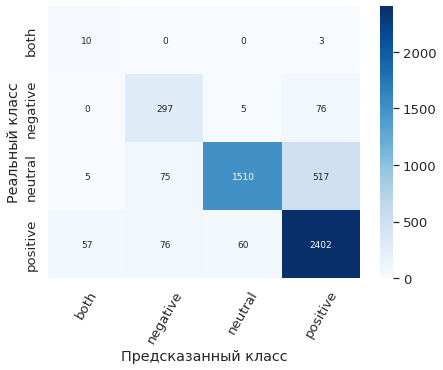

In [67]:
y_test, predicted = text_cls('PassiveAgressive',train_data['Token'],  train_data['sentiment_right'], test_data['Token'], test_data['sentiment_right'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_data, 'sentiment_right', './')

In [68]:
test_data['predicted'] = predicted

In [69]:
test_asp_pred = pd.read_csv(
    'dev_pred_aspects.txt', 
    delimiter='\t', 
    names=['Text_id', 'category', 'Token', 'start', 'end', 'sentiment']
)

In [70]:
del test_data['POS-tag']
del test_data['Lemma']
del test_data['sentiment']

In [71]:
test_data['sentiment'] = test_data['sentiment_right']

In [72]:
del test_data['sentiment_right']

In [73]:
merged_data = test_data.merge(test_asp_pred)

In [74]:
merged_data

,Text_id,Token,predicted,sentiment,category,start,end
0,13823,аппетит,negative,neutral,Whole,8,15
1,13823,встретил,positive,positive,Service,138,146
2,13823,девушка,positive,positive,Service,179,186
3,13823,меню,positive,positive,Food,213,217
4,13823,меню,positive,positive,Food,639,643
...,...,...,...,...,...,...,...
1346,11770,второй,neutral,neutral,Food,733,739
1347,11770,повара,positive,positive,Food,800,806
1348,11770,блюдо,positive,positive,Food,896,901
1349,11770,рыбой,negative,positive,Food,917,922


In [75]:
merged_data.Text_id[0]

13823

In [76]:
with open('dev_pred_aspect_my.txt','w') as f:
  for i in range(len(merged_data.Token)):
    f.write(str(merged_data.Text_id[i]) + '\t' + str(merged_data.category[i]) + '\t' + str(merged_data.Token[i]) + '\t' \
            + str(merged_data.start[i]) + '\t' + str(merged_data.end[i]) + '\t' + str(merged_data.predicted[i]) + '\n')

In [77]:
# categories = merged_data.category.unique()

In [78]:
categories = ['Whole', 'Interior', 'Service', 'Food', 'Price']

In [83]:
categories_ = [] 
for id in merged_data.Text_id.unique():
  text_categories = merged_data[merged_data.Text_id==id][['category', 'predicted']].groupby('category')
  asp_counter = {cat: Counter(vals['predicted'].values) for cat, vals in text_categories}
  for cat in categories:
    if cat not in asp_counter:
      preds = 'absence'
    elif len(asp_counter[cat]) == 1:
      preds = asp_counter[cat].most_common(1)[0][0]
    else:
      preds = 'both'
    categories_.append([id, cat, preds])

reviews_Sentiments = pd.DataFrame(categories_, columns=['text_id', 'category', 'predicted'])

In [84]:
reviews_Sentiments

,text_id,category,predicted
0,13823,Whole,both
1,13823,Interior,absence
2,13823,Service,both
3,13823,Food,positive
4,13823,Price,absence
...,...,...,...
350,11770,Whole,both
351,11770,Interior,positive
352,11770,Service,positive
353,11770,Food,both


In [86]:
with open ('dev_pred_cats_my.txt', 'w') as f:
  for k in range(len(reviews_Sentiments.text_id)):
    f.write(str(reviews_Sentiments.text_id[k]) + '\t' + str(reviews_Sentiments.category[k]) + '\t' + str(reviews_Sentiments.predicted[k]) + '\n')